# Análise Exploratória de Produto do Mercado Livre

## 1. Imports

In [1]:
import sys

In [2]:
import requests
import json
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

## 2. Carregar os Dados

In [3]:
consulta_ml = requests.get("https://api.mercadolibre.com/sites/MLB/search?q=cofre")
consulta_ml = consulta_ml.json()

## 3. Exploração dos Dados

In [4]:
#print(consulta_ml) # coloquei como comentário para não poluir no GitHub

In [5]:
print(type(consulta_ml))

<class 'dict'>


In [6]:
for chave, valor in consulta_ml.items():
    if valor is None:
        print(f"O valor associado à chave '{chave}' é nulo (None)")
    else:
        print("Não há valores nulos")

Não há valores nulos
Não há valores nulos
Não há valores nulos
Não há valores nulos
Não há valores nulos
Não há valores nulos
Não há valores nulos
Não há valores nulos
Não há valores nulos
Não há valores nulos


In [7]:
def percorrer_dicionario(dicionario, nivel=0):
    for chave, valor in dicionario.items():
        print('  ' * nivel + str(chave) + ':', end=' ')
        if isinstance(valor, dict):
            print() 
            percorrer_dicionario(valor, nivel + 1)  
        else:
            print(valor)  
            
# percorrer_dicionario(consulta_ml) # coloquei como comentário para não poluir no GitHub


In [8]:
print("O produto pesquisado é:",consulta_ml['query'])
print("Total de produtos anunciados:",consulta_ml['paging']['total'])
print("Total de produtos listados na primeira página:",consulta_ml['paging']['limit'])

O produto pesquisado é: cofre
Total de produtos anunciados: 11276
Total de produtos listados na primeira página: 50


 Vemos que os dados estão estruturados em um arquivo JSON em que o formato que a gente trabalha aqui dentro do Python é dicionário. O arquivo contém as informações gerais nas primeiras linhas e depois dentro de uma lista com dicionários chamada "Results", temos os 50 resultados que são disponibilizados pela pesquisa quando alguém consulta o ML, mas podemos ver que o total de produtos anunciados de acordo com a pesquisa é de 10.972

## 4. Exploração das Variáveis

A exploração das variáveis vai ser dentro da aba "Results" que mostra o resultado da pesquisa, com 50 produtos anunciados mas com nem todos eles com as variáveis buscadas bem estruturadas dentro do documento. Nem todos os produtos anunciados possuem as variáveis que estamos buscando definidas.

### 4.1 Separar as variáveis em listas

In [9]:
resultados = consulta_ml['results']

In [10]:
# preco = consulta_ml['results'][0]['price']
# preco


precos = []
for resultado in resultados:
    preco = resultado['price']
    precos.append(preco)

#print(precos)

In [11]:
estoques = []

for a in resultados:
    estoque = a['available_quantity']
    estoques.append(estoque)

#print(estoques)

#estoques.count(200)

In [12]:
cores = []

for produto in resultados:
    for atributo in produto['attributes']:
        if atributo['id'] == 'COLOR':
            cores.append(atributo['value_name'])

#print(cores)
#len(cores)

In [13]:
condicao = []
for c in consulta_ml['results']:
    condicoes = c['condition']
    condicao.append(condicoes)

# Imprimir a lista de preços
# print(condicao)

In [14]:
pesos = []

for produto in resultados:
    for atributo in produto['attributes']:
        if atributo['name'] == 'Peso':
            pesos.append(atributo['value_name'])

def converter_para_kg(peso):
    if ' g' in peso:
        peso_em_g = float(peso.split()[0])
        peso_em_kg = peso_em_g / 1000  
        return f'{peso_em_kg:.2f} kg' 
    else:
        return peso

pesos_convertidos = [converter_para_kg(peso) for peso in pesos]

pesos_em_kg = []

for peso in pesos_convertidos:
    if 'kg' in peso:
        peso_em_kg = peso.replace(' kg', '')
        pesos_em_kg.append(float(peso_em_kg))
    else:
        None


print(pesos_em_kg)
len(pesos_em_kg)

[2.4, 4.0, 4.3, 4.35, 14.0, 2.87, 6.0, 4.0, 12.0, 3.5, 14.0, 7.0, 0.57, 2.5, 0.812, 6.5, 3.0, 0.552, 1.31, 3.5, 0.2, 5.0, 6.5, 0.812, 1.31, 14.0, 0.57, 2.87]


28

In [15]:
comprimentos = []

for produto in resultados:
    for atributo in produto['attributes']:
        if atributo['id'] == 'EXTERNAL_LENGTH':
            comprimentos.append(atributo['value_name'])
            
def converter_para_cm(comprimento):
    if 'mm' in comprimento:
        peso_em_mm = float(comprimento.split()[0])
        peso_em_cm = peso_em_mm / 10 
        return f'{peso_em_cm:.0f} cm'  
    else:
        return comprimento

comprimentos_convertidos = [converter_para_cm(comprimento) for comprimento in comprimentos]

comprimentos_limpos = []

for comprimento in comprimentos_convertidos:
    if ' cm' in comprimento:
        comprimento_sem_cm = comprimento.replace(' cm', '')
        comprimento_float = float(comprimento_sem_cm)
        comprimentos_limpos.append(comprimento_float)

print(comprimentos_limpos)

[23.0, 41.0, 31.0, 20.0, 20.0, 31.0, 17.0, 25.0, 41.0, 25.0, 31.0, 37.0, 25.0, 12.0, 24.0, 10.7, 30.0, 31.0, 33.0, 44.0, 13.5, 10.7, 11.0, 10.0, 23.5, 10.0, 32.0, 23.0, 10.5, 24.0, 10.7, 10.0, 25.0, 15.0, 11.5, 25.0, 20.0, 4.0, 31.0, 4.0, 31.0, 23.5, 24.0, 40.0, 21.0, 25.0, 13.5, 17.0]


In [16]:
titulos = []
for t in consulta_ml['results']:
    titulo = resultado['title']
    titulos.append(titulo)
    
#print(titulos)
#len(titulos)

### 4.2 Criar um DF com as variáveis

In [17]:
def padronizar_lista(lista, length):
    if len(lista) < length:
        lista += [None] * (length - len(lista))
    return lista[:length]  

max_length = 50

lista_nome = padronizar_lista(titulos, max_length)
lista_cor = padronizar_lista(cores, max_length)
lista_peso = padronizar_lista(pesos_em_kg, max_length)
lista_preco = padronizar_lista(precos, max_length)
lista_comprimento = padronizar_lista(comprimentos_limpos, max_length)
lista_condicao = padronizar_lista(condicao, max_length)
lista_estoques = padronizar_lista(estoques, max_length)

dados_ml = {
    'Nome': titulos,
    'Cor': cores,
    'Peso': pesos_em_kg,
    'Preço': precos,
    'Comprimento': comprimentos_limpos,
    'Condição': condicao,
    'Estoques': estoques
}

df_ml = pd.DataFrame(dados_ml)

df_ml.fillna('', inplace=True)
df_ml = df_ml.replace('', np.nan)

df_ml

,Nome,Cor,Peso,Preço,Comprimento,Condição,Estoques
0,Cofre Eletrônico Digital Senha Ou Chave 23x17x17,Preto,2.400,133.12,23.0,new,500
1,Cofre Eletrônico Digital Senha Ou Chave 23x17x17,Cinza,4.000,105.00,41.0,new,1
2,Cofre Eletrônico Digital Senha Ou Chave 23x17x17,Preto,4.300,218.30,31.0,new,50
3,Cofre Eletrônico Digital Senha Ou Chave 23x17x17,Preto,4.350,329.99,20.0,new,1
4,Cofre Eletrônico Digital Senha Ou Chave 23x17x17,Preto,14.000,228.96,20.0,new,500
5,Cofre Eletrônico Digital Senha Ou Chave 23x17x17,Preto,2.870,573.99,31.0,new,100
6,Cofre Eletrônico Digital Senha Ou Chave 23x17x17,Preto,6.000,133.66,17.0,new,150
7,Cofre Eletrônico Digital Senha Ou Chave 23x17x17,Preto,4.000,297.50,25.0,new,100
8,Cofre Eletrônico Digital Senha Ou Chave 23x17x17,Preto,12.000,106.00,41.0,new,150
9,Cofre Eletrônico Digital Senha Ou Chave 23x17x17,Preto,3.500,243.59,25.0,new,1


### 4.3 Explorar variáveis no DF

In [18]:
df_ml.dtypes

Nome            object
Cor             object
Peso           float64
Preço          float64
Comprimento    float64
Condição        object
Estoques         int64
dtype: object

In [19]:
df_ml.describe()

,Peso,Preço,Comprimento,Estoques
count,28.000000,50.000000,48.000000,50.000000
mean,4.586643,268.300600,22.314583,67.620000
std,4.192575,342.127376,10.081392,127.688059
min,0.200000,19.460000,4.000000,1.000000
25%,1.310000,107.250000,13.125000,1.000000
50%,3.500000,145.400000,23.500000,1.000000
75%,6.125000,297.800000,31.000000,100.000000
max,14.000000,2074.560000,44.000000,500.000000


In [20]:
valores_vazios_cor = (df_ml['Cor'] == '').sum()

print(f"Total de valores faltantes na coluna 'Cor': {valores_vazios_cor}")

valores_vazios_peso = (df_ml['Peso'] == '').sum()

print(f"Total de valores faltantes na coluna 'Peso': {valores_vazios_peso}")

valores_vazios_comprimento = (df_ml['Comprimento'] == '').sum()

print(f"Total de valores faltantes na coluna 'Comprimento': {valores_vazios_comprimento}")

Total de valores faltantes na coluna 'Cor': 0
Total de valores faltantes na coluna 'Peso': 0
Total de valores faltantes na coluna 'Comprimento': 0


## 5. Análise das variáveis

   ### 5.1 Preço dos itens

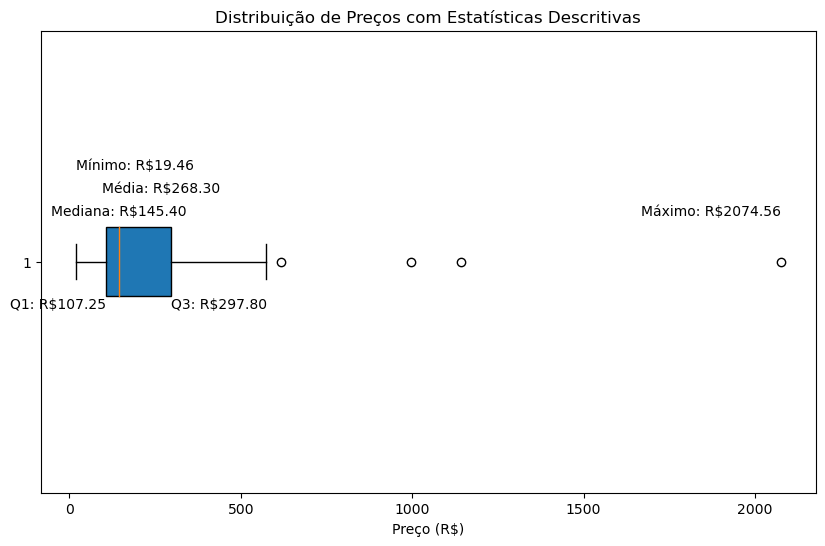

In [21]:
media = np.mean(precos)
mediana = np.median(precos)
minimo = np.min(precos)
maximo = np.max(precos)
q1, q2, q3 = np.percentile(precos, [25, 50, 75])

plt.figure(figsize=(10, 6))
plt.boxplot(precos, vert=False, patch_artist=True)
plt.xlabel('Preço (R$)')
plt.title('Distribuição de Preços com Estatísticas Descritivas')

plt.text(maximo, 1.1, f'Máximo: R${maximo:.2f}', fontsize=10, ha='right')
plt.text(minimo, 1.2, f'Mínimo: R${minimo:.2f}', fontsize=10, ha='left')
plt.text(q1, 0.9, f'Q1: R${q1:.2f}', fontsize=10, ha='right')
plt.text(q3, 0.9, f'Q3: R${q3:.2f}', fontsize=10, ha='left')
plt.text(media, 1.15, f'Média: R${media:.2f}', fontsize=10, ha='center')
plt.text(mediana, 1.1, f'Mediana: R${mediana:.2f}', fontsize=10, ha='center')

plt.show()

Como podemos ver no boxplot a maior parte dos preços dos produtos estão concentrados (50%) entre 115.21 e 306.8 . Vemos também que os produtos com preços altos como próximo do peso máximo na amostra, são outliers, ou seja, minoria no conjunto de dados. A média de preços está em 257.7, já a mediana em 161.62, então vemos que boa parte dos preços estão de fato situados em valores menores.

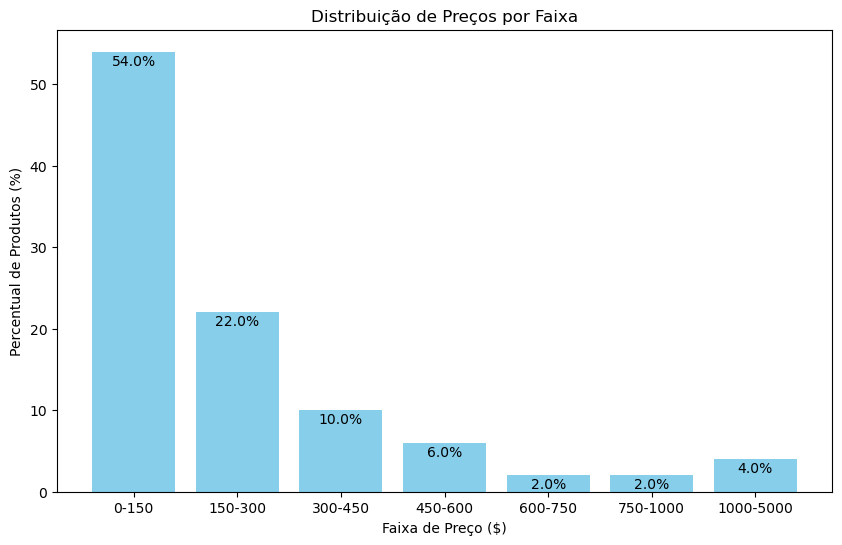

In [22]:
faixas_preco = [(0, 150), (150, 300), (300, 450), (450, 600), (600, 750), (750, 1000),(1000, 5000)]

contagem_por_faixa = [sum(1 for preco in precos if faixa[0] <= preco < faixa[1]) for faixa in faixas_preco]

total_produtos = len(precos)

percentual_por_faixa = [round((contagem / total_produtos),2) * 100 for contagem in contagem_por_faixa]

labels_faixas = [f'{faixa[0]}-{faixa[1]}' for faixa in faixas_preco]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels_faixas, percentual_por_faixa, color='skyblue')

for bar, percentual in zip(bars, percentual_por_faixa):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 2, f'{percentual}%', 
             ha='center', va='bottom', color='black', fontsize=10)

plt.title('Distribuição de Preços por Faixa')
plt.xlabel('Faixa de Preço ($)')
plt.ylabel('Percentual de Produtos (%)')

plt.show()

Vemos que a maioria dos produtos tem preços na faixa de até 150 (arredondando) e que acima de 300 a quantidade de produtos vai decrescendo gradativamente

### 5.2 Estoques

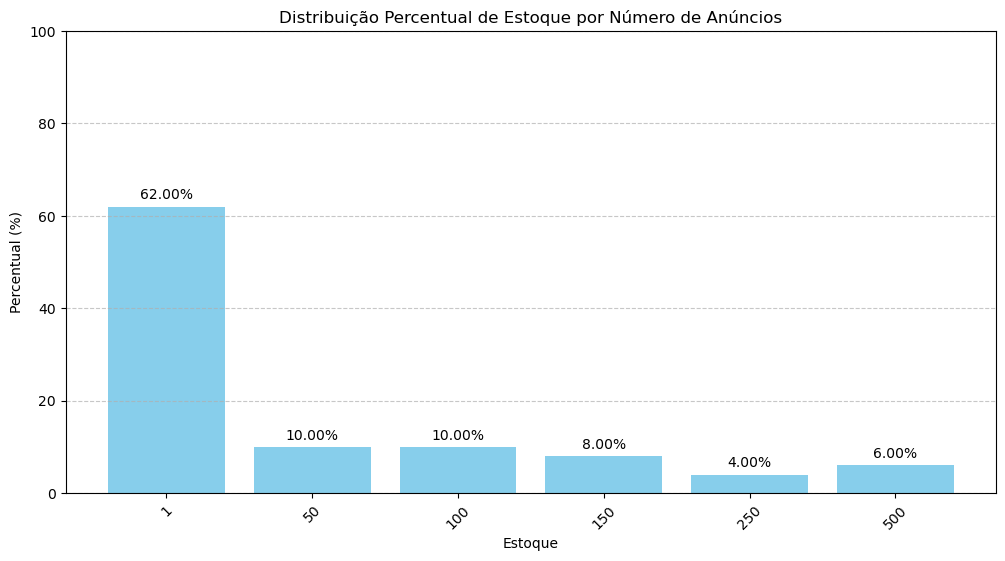

In [23]:
ocorrencias = Counter(estoques)

total_anuncios = len(estoques)

percentuais = {valor: (ocorrencias[valor] / total_anuncios) * 100 for valor in ocorrencias}

valores_ordenados = sorted(percentuais.keys())

plt.figure(figsize=(12, 6))
plt.bar([str(valor) for valor in valores_ordenados], [percentuais[valor] for valor in valores_ordenados], color='skyblue')
plt.xlabel('Estoque')
plt.ylabel('Percentual (%)')
plt.title('Distribuição Percentual de Estoque por Número de Anúncios')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.ylim(0, 100)

for i, valor in enumerate(valores_ordenados):
    percentual = percentuais[valor]
    plt.text(i, percentual + 1, f'{percentual:.2f}%', ha='center', va='bottom')

plt.show()

Vemos que por alguma razão 68% dos produtos tem estoque de apenas 1 produto. Algo preocupante visto que isso pode afetar diretamente nas vendas dos vendedores do ML e afetar possíveis compradores que desejam adquirir mais de um produto

### 5.3 Cor dos itens

Vemos que para a variável como cor não temos todas as correspondências dos 50 produtos anunciados

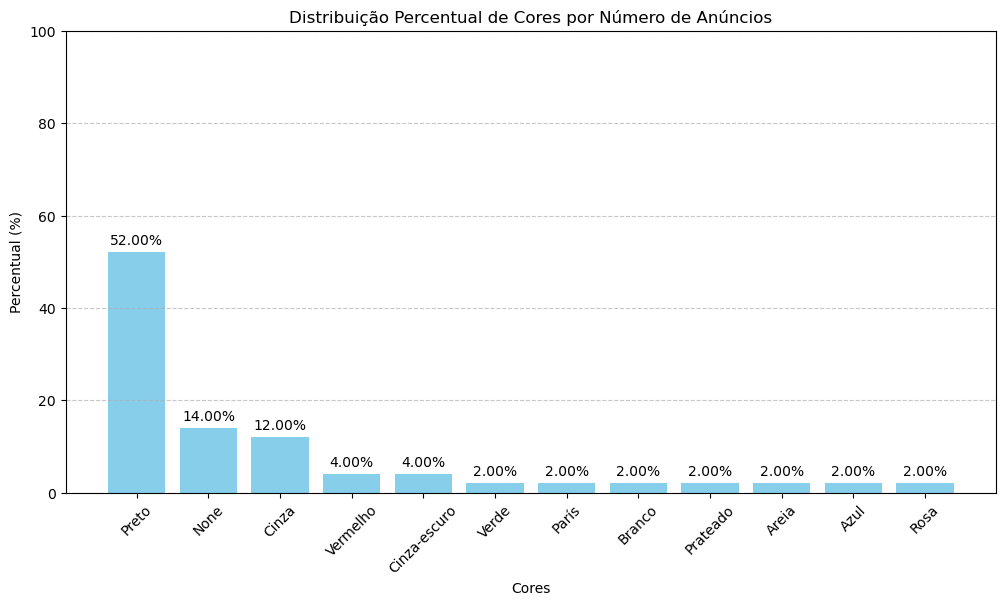

In [24]:
ocorrencias_cores = Counter(cores)

total_cores = len(cores)

percentuais_cores = {cor: (ocorrencias_cores[cor] / total_cores) * 100 for cor in ocorrencias_cores}

valores_ordenados_cores = sorted(percentuais_cores.items(), key=lambda x: x[1], reverse=True)

cores_ordenadas = [str(cor[0]) for cor in valores_ordenados_cores]
percentuais_ordenados = [cor[1] for cor in valores_ordenados_cores]

plt.figure(figsize=(12, 6))
plt.bar(cores_ordenadas, percentuais_ordenados, color='skyblue')
plt.xlabel('Cores')
plt.ylabel('Percentual (%)')
plt.title('Distribuição Percentual de Cores por Número de Anúncios')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.ylim(0, 100)

for i, percentual in enumerate(percentuais_ordenados):
    plt.text(i, percentual + 1, f'{percentual:.2f}%', ha='center', va='bottom')

plt.show()

Vemos que boa parte dos produtos são da cor preta (68,4%), seguidos da cor cinza (18,4%). O restante das cores representa uma baixa quantidade de produtos. Mostra que possívelmente a cor não é um parâmetro extremamente relevante no momento da compra

### 5.4 Condição 

In [25]:
contagem_condicoes = {'novo': len(condicao)}
contagem_condicoes
# labels = contagem_condicoes.keys()
# sizes = contagem_condicoes.values()

# plt.figure(figsize=(5, 5))
# plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
# plt.title('Distribuição da Condição dos Produtos')
# plt.axis('equal')  # Assegura que o gráfico de pizza é desenhado como um círculo

# plt.show()

{'novo': 50}

Todos os produtos analisados são novos

### 5.5 Peso 

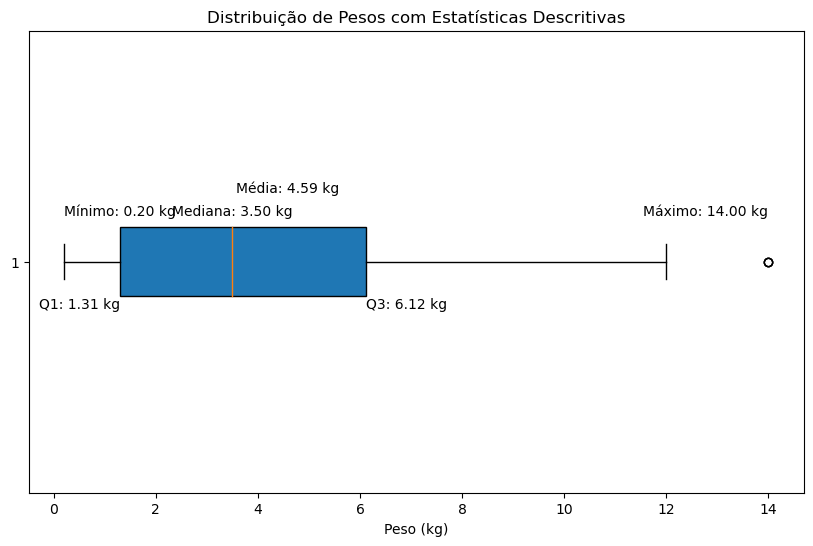

In [28]:
pesos_validos = [valor for valor in pesos_em_kg if valor is not None and not np.isnan(valor)]

media = np.mean(pesos_validos)
mediana = np.median(pesos_validos)
minimo = np.min(pesos_validos)
maximo = np.max(pesos_validos)
q1, q2, q3 = np.percentile(pesos_validos, [25, 50, 75])

plt.figure(figsize=(10, 6))
plt.boxplot(pesos_validos, vert=False, patch_artist=True)
plt.xlabel('Peso (kg)')
plt.title('Distribuição de Pesos com Estatísticas Descritivas')

plt.text(maximo, 1.1, f'Máximo: {maximo:.2f} kg', fontsize=10, ha='right')
plt.text(minimo, 1.1, f'Mínimo: {minimo:.2f} kg', fontsize=10, ha='left')
plt.text(q1, 0.9, f'Q1: {q1:.2f} kg', fontsize=10, ha='right')
plt.text(q3, 0.9, f'Q3: {q3:.2f} kg', fontsize=10, ha='left')
plt.text(media, 1.15, f'Média: {media:.2f} kg', fontsize=10, ha='center')
plt.text(mediana, 1.1, f'Mediana: {mediana:.2f} kg', fontsize=10, ha='center')

plt.show()

Como podemos ver no boxplot a maior parte dos pesos dos produtos estão concentrados (50%) entre 1.58kg e 5.75kg. Vemos também que os produtos com pesos altos como próximo do peso máximo na amostra, são outliers, ou seja, minoria no conjunto de dados. A média de pesos está em 4.65kg, já a mediana em 3.75kg, então vemos que a amplitude maior em relação a pesos maiores provavelmente está puxando a média um pouco pra cima (os outliers ajudam também).

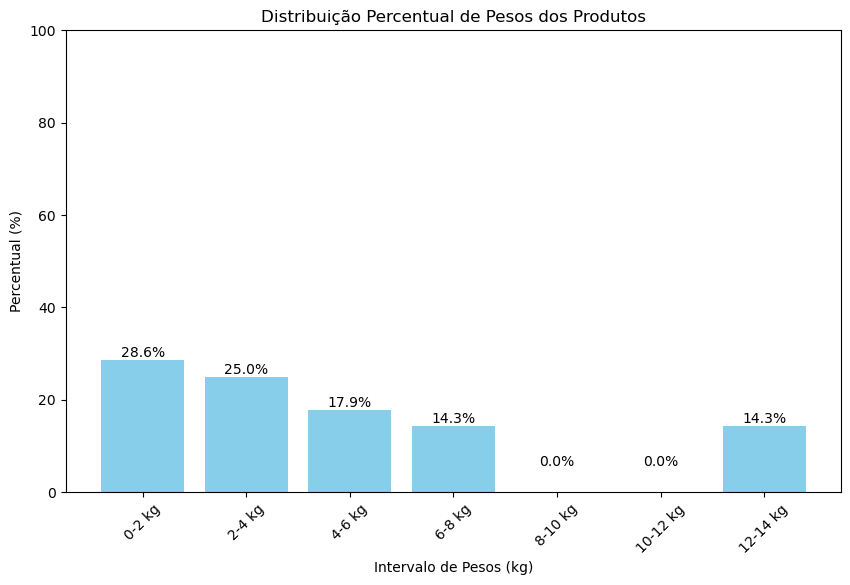

In [30]:
bins = [0, 2, 4, 6, 8, 10, 12, 14]

pesos_validos = [valor for valor in pesos_em_kg if valor is not None and not np.isnan(valor)]

percentual_por_intervalo, _ = np.histogram(pesos_validos, bins=bins, density=False)

total_produtos = len(pesos_validos)
percentual_por_intervalo = percentual_por_intervalo / total_produtos * 100

labels = [f'{bins[i]}-{bins[i+1]} kg' for i in range(len(bins)-1)]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, percentual_por_intervalo, color='skyblue')
plt.xlabel('Intervalo de Pesos (kg)')
plt.ylabel('Percentual (%)')
plt.title('Distribuição Percentual de Pesos dos Produtos')
plt.ylim(0, 100)  

for bar, percentual in zip(bars, percentual_por_intervalo):
    y_pos = max(bar.get_height(), 5)  
    plt.text(bar.get_x() + bar.get_width() / 2, y_pos,
             f'{percentual:.1f}%', ha='center', va='bottom')

plt.xticks(rotation=45) 
plt.show()

O gráfico ajuda a entender melhor o que já foi repassado acima, mostrando melhor a distribuição em percentual por faixa de peso dos produtos. Vemos que a maioria dos produtos está concentrada de 0 até 6kg (73,3%), mas há um nicho do produto com um peso maior (12-14kg)

### 5.6 Tamanho 

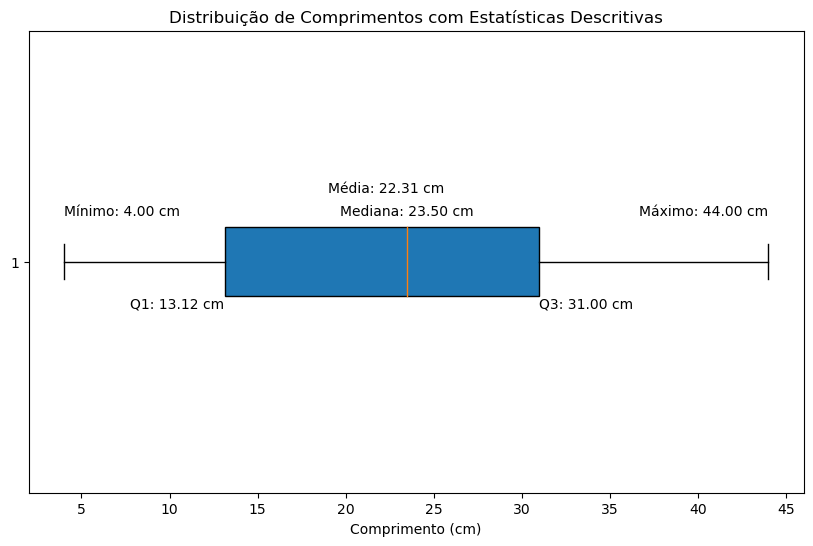

In [32]:
tamanho_validos = [valor for valor in comprimentos_limpos if valor is not None and not np.isnan(valor)]


media = np.mean(tamanho_validos)
mediana = np.median(tamanho_validos)
minimo = np.min(tamanho_validos)
maximo = np.max(tamanho_validos)
q1, q2, q3 = np.percentile(tamanho_validos, [25, 50, 75])

plt.figure(figsize=(10, 6))
plt.boxplot(tamanho_validos, vert=False, patch_artist=True)
plt.xlabel('Comprimento (cm)')
plt.title('Distribuição de Comprimentos com Estatísticas Descritivas')

plt.text(maximo, 1.1, f'Máximo: {maximo:.2f} cm', fontsize=10, ha='right')
plt.text(minimo, 1.1, f'Mínimo: {minimo:.2f} cm', fontsize=10, ha='left')
plt.text(q1, 0.9, f'Q1: {q1:.2f} cm', fontsize=10, ha='right')
plt.text(q3, 0.9, f'Q3: {q3:.2f} cm', fontsize=10, ha='left')
plt.text(media, 1.15, f'Média: {media:.2f} cm', fontsize=10, ha='center')
plt.text(mediana, 1.1, f'Mediana: {mediana:.2f} cm', fontsize=10, ha='center')

plt.show()

Como podemos ver no boxplot a maior parte do comprimento dos produtos estão concentrados (50%) entre 17cm e 31cm. A média de comprimento está em 23.79cm, já a mediana em 23.75, então vemos a amostra de comprimentos dos produtos está bem distribuida, o que é explicado também pela ausência de outliers.

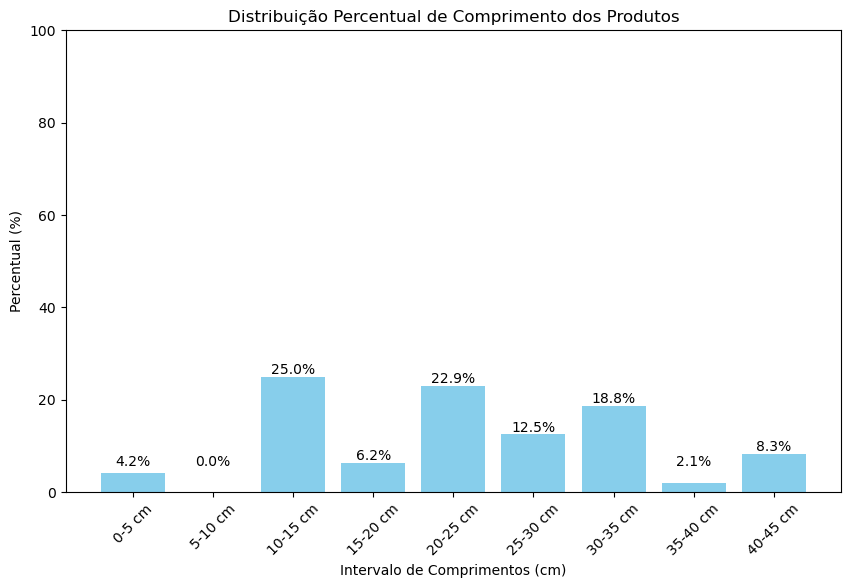

In [33]:
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]

percentual_por_intervalo_comprimento, _ = np.histogram(tamanho_validos, bins=bins, density=False)

total_produtos_comprimento = len(tamanho_validos)

percentual_por_intervalo_comprimento = percentual_por_intervalo_comprimento / total_produtos_comprimento * 100

labels = [f'{bins[i]}-{bins[i+1]} cm' for i in range(len(bins)-1)]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, percentual_por_intervalo_comprimento, color='skyblue')
plt.xlabel('Intervalo de Comprimentos (cm)')
plt.ylabel('Percentual (%)')
plt.title('Distribuição Percentual de Comprimento dos Produtos')
plt.ylim(0, 100) 

for bar, percentual in zip(bars, percentual_por_intervalo_comprimento):
    y_pos = max(bar.get_height(), 5) 
    plt.text(bar.get_x() + bar.get_width() / 2, y_pos,
             f'{percentual:.1f}%', ha='center', va='bottom')

plt.xticks(rotation=45) 
plt.show()

O que já foi mostrado no boxplot acima, aqui é ressaltado. Temos uma amostra de comprimento bem distribuida com uma maior concentração de comprimento em torno dos valores médios considerando o range de comprimento da amostra.

### 5.7 Títulos dos Anúncios

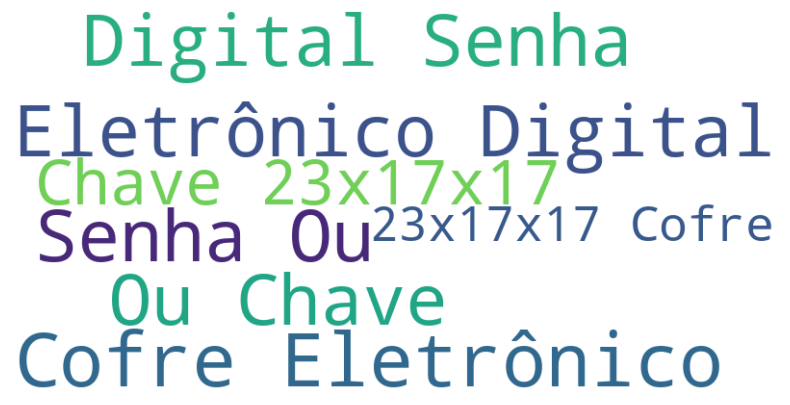

In [34]:
texto = ' '.join(titulos)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Oculta os eixos
plt.show()

Aqui conseguimos ver de forma lúdica, as principais palavras usadas como título do produto.

### 5.8 Análise Bivariada

#### 5.8.1 Peso e Preço

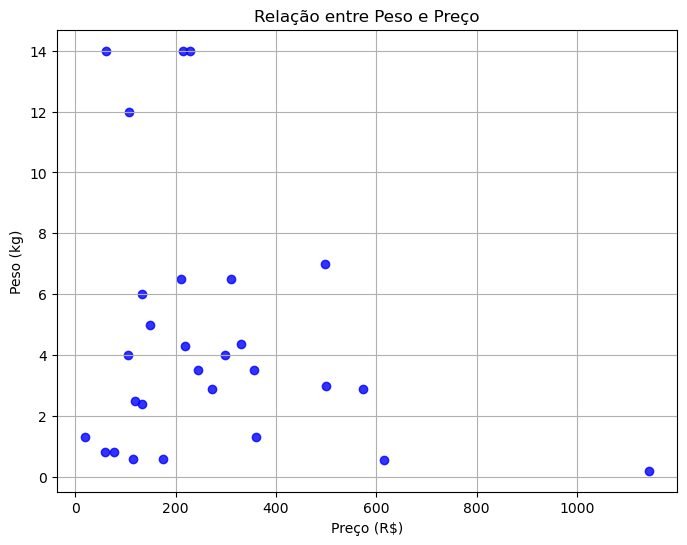

In [35]:
plt.figure(figsize=(8, 6))
plt.scatter(df_ml['Preço'], df_ml['Peso'], color='blue', alpha=0.8)
plt.title('Relação entre Peso e Preço')
plt.xlabel('Preço (R$)')
plt.ylabel('Peso (kg)')
plt.grid(True)
plt.show()

In [36]:
correlation = df_ml['Peso'].corr(df_ml['Preço'])
print(f"Correlação entre Peso e Preço: {correlation:.2f}")

Correlação entre Peso e Preço: -0.24


Observando o gráfico de dispersão entre peso e preço, notamos que a relação entre essas duas variáveis é uma relação negativa fraca. Vemos que os produtos com menor preço tendem a ser os mais pesados e os produtos mais caros tendem a serem mais leves, mas não de forma predominante. Isso sugere que o preço de um produto pode ser influenciado por uma variedade de fatores além do peso, como marca, qualidade e design.

A correlação entre Peso e Preço de -0.24 indica uma correlação fraca entre essas duas variáveis. Quando a correlação é próxima de zero, como é o caso aqui, sugere que há uma relação negativa fraca entre o peso de um produto e seu preço.


#### 5.8.2 Comprimento e Preço

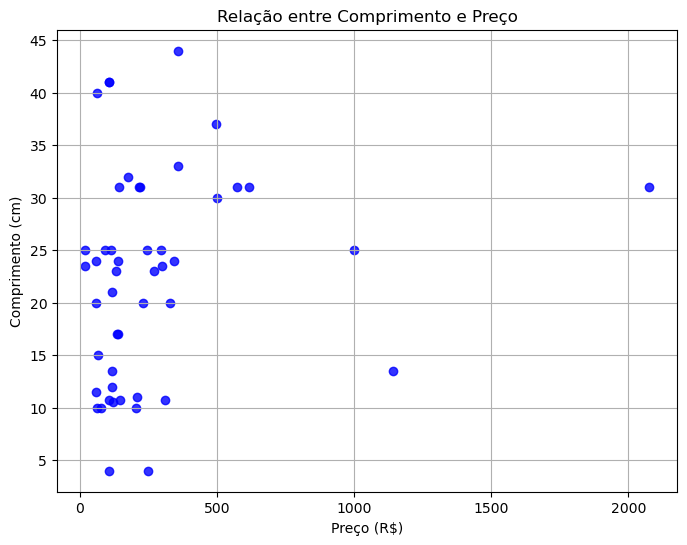

In [37]:
plt.figure(figsize=(8, 6))
plt.scatter(df_ml['Preço'], df_ml['Comprimento'], color='blue', alpha=0.8)
plt.title('Relação entre Comprimento e Preço')
plt.xlabel('Preço (R$)')
plt.ylabel('Comprimento (cm)')
plt.grid(True)
plt.show()

In [38]:
correlation = df_ml['Comprimento'].corr(df_ml['Preço'])
print(f"Correlação entre Comprimento e Preço: {correlation:.2f}")

Correlação entre Comprimento e Preço: 0.19


Observando o gráfico de dispersão entre comprimento e preço, notamos uma associação fraca e positiva entre essas duas variáveis. Embora alguns produtos mais compridos possam ter preços mais altos, também observamos que produtos menores podem ter preços elevados. Ainda assim, há uma tendência fraca de os produtos mais caros apresentarem comprimentos maiores, embora essa relação não seja definitiva. Por exemplo, o produto mais caro encontrado no conjunto de dados tem cerca de 25 cm, e um dos produtos mais longos (40 cm) também é um dos mais caros, evidenciando essa relação positiva fraca. Isso sugere que o preço de um produto pode ser influenciado pelo tamanho, mas outros fatores como marca, qualidade e design também desempenham papéis significativos na determinação do preço.

A correlação de 0.28 evidência os pontos destacados acima.

##### OBS: Uma maior amostragem de dados seria importante para analisar melhor as correlações entre as variáveis. O tamanho da amostra impacta diretamente na capacidade de inferir precisamente correlações.

## 6. Conclusões

### 6.1 Sobre o formato dos dados

O arquivo é no formato JSON e realizei a análise explorando esses dados inicialmente no formato de dicionário que é a forma que encontramos aqui no Python de trabalhar esse arquivo. Posteriormente separei as variáveis desejadas em listas, depois inclui todas essas listas em um DF, cada uma como uma coluna para poder explorar melhor essas variáveis. 

### 6.2 Sobre os dados analisados

Eu realizei a análise dos 50 produtos que são disponibilizados pelo documento via a API. Um ponto importante é destacar que nem todos os produtos tem algumas variáveis importantes preenchidas no documento da API do Mercado Livre.

E apesar da busca trazer 50 produtos, a busca tem um total de 10972 produtos anunciados. Seria interessante pensar numa forma de conseguir analisar de uma vez só uma quantidade maior de produtos anunciados a fim de ter uma amostragem mais completa e assim uma análise mais aprofundada sobre os produtos que são vendidos no Mercado Livre de acordo com determinada busca. 

É importante observar que como os anúncios estão em constante alteração, 

### 6.3 Sobre a análise

Fiz uma análise que aprofunda nas principais características dos produtos que são vendidos no Mercado Livre, que facilite ter uma visão mais descritiva dos diferentes produtos anunciados para uma determinada pesquisa, através de uma análise univariada (cor, tamanho, peso, preço, título do anúncio, estoque e condição do produto) e como algumas desssas variáveis se relacionam entre si (análise bivariada)

### 6.4 Conclusão da análise

Sobre a pesquisa "Cofre" em específico, vemos que é um produto que tende a ter um valor mais baixo (em sua grande maioria até 300 reais), com um tamanho variado e em sua maioria com um menor peso. Os vendedores apostam na venda do produto novo e aparentemente a cor do produto não é uma preocupação dos vendedores (e provavelmente dos compradores também). Os vendedores tem apostado em um anúncio que destaca muito o aparelho ser eletrônico, digital e/ou automático (pode alterar).

## 7. Próximos passos

Há uma parte no fim do documento em que há alguns filtros que são interessantes de serem analisados posteriormente. Há o percentual de desconto, filtro por marcas, por região do Brasil, faixa de preço, modo de pagamento (com juros e sem juros) e faixa de preço. Os filtros são sobre o número total de produtos (10972).